In [20]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fredapi import Fred

def read_api_key_from_file():
    file_path = 'fred_api_key.txt'
    with open(file_path, 'r') as file:
        api_key = file.read().strip()
    return api_key

def fetch_series(series_id, api_key, fetch_last = False):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'
    if fetch_last:
        response = requests.get(url+'&limit=1&sort_order=desc')
    else:
        response = requests.get(url)
    response.raise_for_status()  # Raise an HTTPError for bad responses
    data = response.json()['observations']

    if fetch_last:
        latest_value = None
        if data:
            latest_value = float(data[0]['value'])
        return latest_value
    
    series_data = {}
    for item in data:
        try:
            date = item['date']
            value = float(item['value'])
            series_data[date] = value
        except (KeyError, ValueError):
            pass  # Skip over invalid values
    
    return pd.Series(series_data)

# Function to construct the RealFlation DataFrame directly from the FRED API
def constructDF(api_key):
    expinf10yr = fetch_series('EXPINF10YR', api_key)
    reaintratrearat10y = fetch_series('REAINTRATREARAT10Y', api_key)
    fedfunds = fetch_series('FEDFUNDS', api_key)

    data = pd.DataFrame({
        'EXPINF10YR': expinf10yr,
        'REAINTRATREARAT10Y': reaintratrearat10y,
        'FEDFUNDS': fedfunds
    })

    # Drop rows with missing values
    data.dropna(inplace=True)
    
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    
    # Create the Real10YrInflInterest series
    data['Real10YrInflInterest'] = data['REAINTRATREARAT10Y'] + data['EXPINF10YR']
    
    return data

def shade_recession_months(ax, usrec_series):
    """
    Shade the recession months based on the "USREC" series.

    Parameters:
        ax (matplotlib.axes.Axes): The Axes object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    # Iterate over the series and shade the recession months
    for date, value in usrec_series.items():
        # Convert date to datetime object
        date = pd.to_datetime(date)
        
        if value == 1:
            ax.axvspan(date, date + pd.DateOffset(months=1), color='grey', alpha=0.3, linewidth=0)

if __name__ == "__main__":
    today = pd.Timestamp.now().date()
    arbitrary_start_date = datetime.strptime('01-01-2002', "%m-%d-%Y")    
    offsetDays = 2000

    api_key = read_api_key_from_file()
    
    # Construct the RealFlation DataFrame directly from the FRED API
    RealFlation = constructDF(api_key)
    
    # Set the arbitrary start date if not provided
    if arbitrary_start_date is None:
        arbitrary_start_date = RealFlation.index[1]
    
    # Filter the RealFlation DataFrame based on the arbitrary start date
    RealFlation_filtered = RealFlation.loc[arbitrary_start_date:]
    
    # Plot the filtered RealFlation data
    fig, ax = plt.subplots(figsize=(20, 10))
    RealFlation_filtered.plot(ax=ax, legend=None)
    
    plt.title('Interest Rate Dynamics: Expected Inflation, Real Rate, and Fed Funds Rate', fontsize=14, weight='bold')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    
    # Set x-axis limits to include additional offset days
    x_min = RealFlation_filtered.index.min()
    x_max = RealFlation_filtered.index.max() + pd.DateOffset(days=offsetDays)
    plt.xlim(x_min, x_max)
    
    # Shade the recession periods based on the "USREC" series
    usrec_series = fetch_series('USREC', api_key)
    shade_recession_months(ax, usrec_series)
    
    # Fetch the current 10-year Treasury yield (DGS10) and display it as a reference
    current_dgs10 = fetch_series('DGS10', api_key, True)
    # Plot the data
    if current_dgs10 is not None:
        dgs10_legend = plt.axhline(y=current_dgs10, color='red', linewidth=1, linestyle='--', alpha=0.7, label='10-Year Treasury Yield')
        # plt.text(.98, current_dgs10 - 1, 'Current DGS10: {}'.format(current_dgs10), color='red', fontsize=10, ha='right', va='center')
        # plt.text(0.98, 020., f'Current 10-Year Treasury Yield (DGS10): {current_dgs10}', 
        #          transform=plt.gca().transAxes, fontsize=10, color='black', ha='right', va='bottom')
    else:
        print("Failed to fetch the current 10-year Treasury yield.")

   # Annotate the end values of specific columns on the plot
    for column in ['EXPINF10YR', 'REAINTRATREARAT10Y', 'Real10YrInflInterest', 'FEDFUNDS']:
        end_date = RealFlation_filtered.index[-1]
        end_value = RealFlation_filtered[column].iloc[-1]
        plt.annotate(f'{column}: {end_value:.2f}', xy=(end_date, end_value),
                     xytext=(10, -10), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->"))
        
    # Add most recent date and arbitrary start date
    most_recent_date = RealFlation.index.max()
    plt.text(0.98, 0.98, f'Most Recent Data: {most_recent_date.date()}\nArbitrary Start Date: {arbitrary_start_date.date()}', 
             transform=plt.gca().transAxes, fontsize=12, color='grey', ha='right', va='top')
    
    # Add signature text to the plot
    signature_text = 'Helms Deep\nInterest Rate Series'
    # add_signature(fig, signature_text)
    plt.figtext(.9, 0, signature_text, ha='right', fontsize=12, color='grey')
    
    # Add source from FRED St. Louis on the left
    plt.figtext(0.1, 0, 'Source: Federal Reserve Bank of St. Louis\nUpdated: {}'.format(today), ha='left', fontsize=12, color='grey')

    recession_legend = plt.Rectangle((0,0), 0, 0, fc='grey', alpha=0.3, label='Recessions')
    plt.legend(handles=[dgs10_legend, recession_legend], loc="lower right")
    
    # Display the plot and save the figure 
    plt.show()
    fig.savefig('interest_rate_dynamics.png', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'fred_api_key.txt'

<bound method NDFrame.tail of             EXPINF10YR  REAINTRATREARAT10Y  FEDFUNDS  Real10YrInflInterest
1982-01-01    6.197611            7.623742     13.22             13.821354
1982-02-01    6.079232            7.656648     14.78             13.735880
1982-03-01    5.648130            7.128993     14.68             12.777123
1982-04-01    5.713188            7.408347     14.94             13.121536
1982-05-01    5.689980            7.320041     14.45             13.010021
...                ...                 ...       ...                   ...
2024-02-01    2.146201            1.616823      5.33              3.763024
2024-03-01    2.218753            1.925969      5.33              4.144722
2024-04-01    2.342961            1.938194      5.33              4.281155
2024-05-01    2.451501            2.103399      5.33              4.554900
2024-06-01    2.369874            1.999553      5.33              4.369428

[510 rows x 4 columns]>
<class 'pandas._libs.tslibs.timestamps.Timest

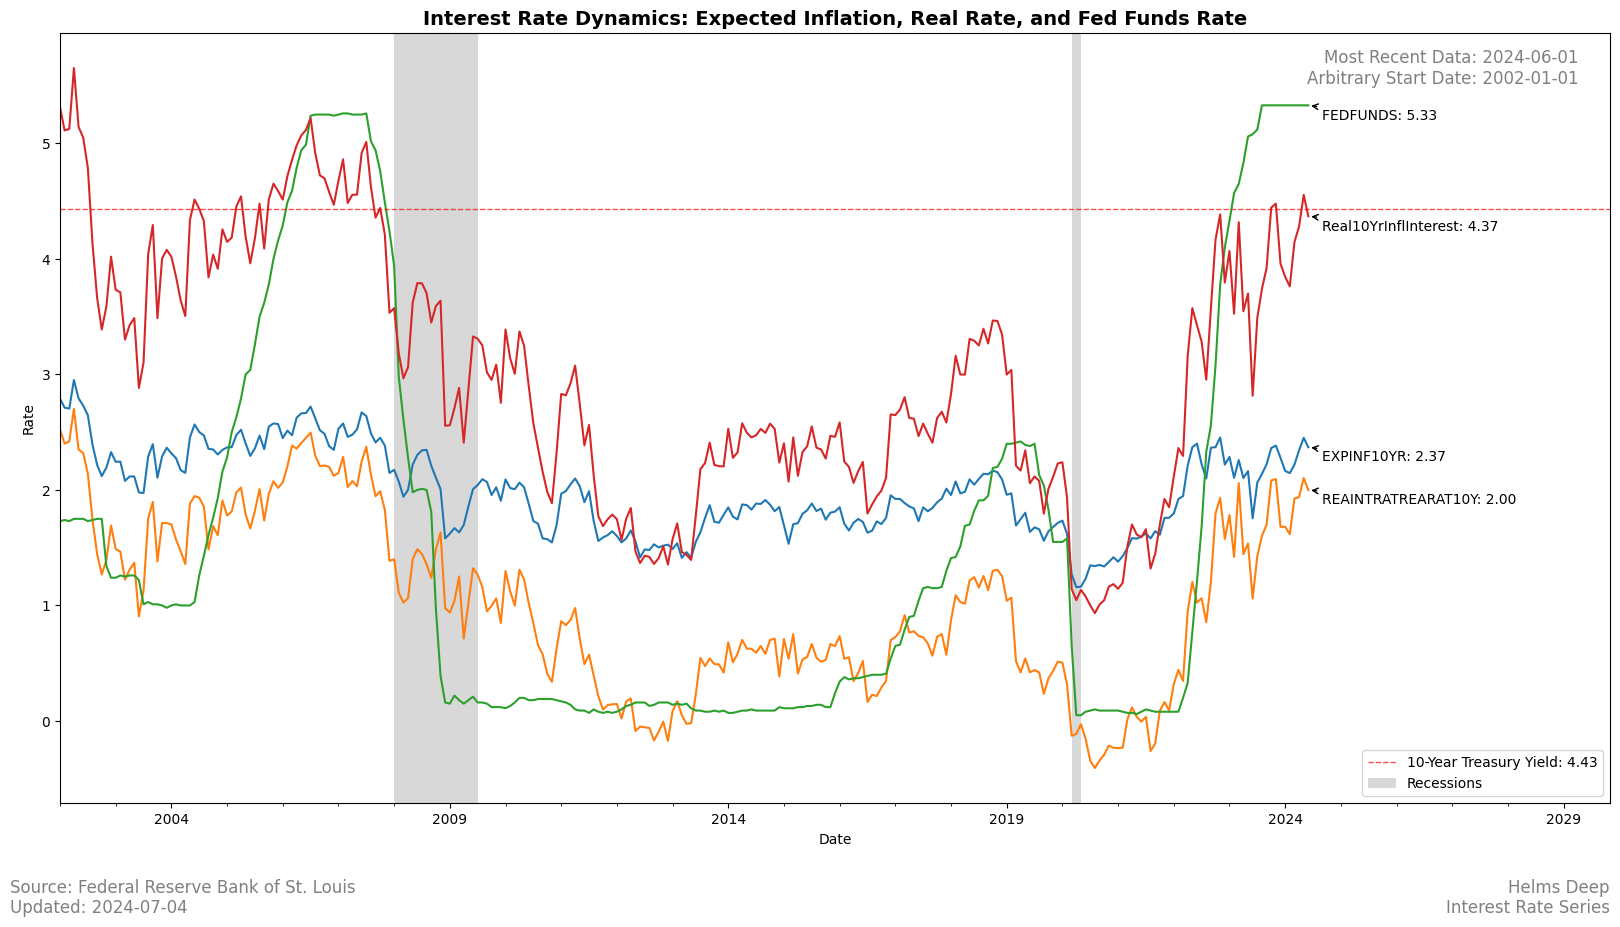

In [8]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher

def constructDF():
    """
    Constructs the RealFlation DataFrame by fetching data from the FRED API.

    Returns:
        pd.DataFrame: DataFrame containing the data for 'EXPINF10YR', 
                      'REAINTRATREARAT10Y', 'FEDFUNDS', and 'Real10YrInflInterest'.
    """
    expinf10yr = SeriesFetcher('EXPINF10YR')
    reaintratrearat10y = SeriesFetcher('REAINTRATREARAT10Y')
    fedfunds = SeriesFetcher('FEDFUNDS')

    data = pd.DataFrame({
        'EXPINF10YR': expinf10yr.get_series_data(),
        'REAINTRATREARAT10Y': reaintratrearat10y.get_series_data(),
        'FEDFUNDS': fedfunds.get_series_data()
    })

    # Drop rows with missing values
    data.dropna(inplace=True)
    
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    
    # Create the Real10YrInflInterest series
    data['Real10YrInflInterest'] = data['REAINTRATREARAT10Y'] + data['EXPINF10YR']
    
    return data

def shade_recession_months(ax, usrec_series):
    """
    Shades the recession months based on the "USREC" series.

    Parameters:
        ax (matplotlib.axes.Axes): The Axes object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            ax.axvspan(date, date + pd.DateOffset(months=1), color='grey', alpha=0.3, linewidth=0)

if __name__ == "__main__":
    today = pd.Timestamp.now().date()
    arbitrary_start_date = datetime.strptime('01-01-2002', "%m-%d-%Y")    
    offset_days = 2000
    
    # Construct the RealFlation DataFrame
    RealFlation = constructDF()
    
    # Set the arbitrary start date if not provided
    if arbitrary_start_date is None:
        arbitrary_start_date = RealFlation.index[1]
    
    # Filter the RealFlation DataFrame based on the arbitrary start date
    RealFlation_filtered = RealFlation.loc[arbitrary_start_date:]
    
    # Plot the filtered RealFlation data
    fig, ax = plt.subplots(figsize=(20, 10))
    RealFlation_filtered.plot(ax=ax, legend=None)
    
    plt.title('Interest Rate Dynamics: Expected Inflation, Real Rate, and Fed Funds Rate', fontsize=14, weight='bold')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    
    # Set x-axis limits to include additional offset days
    x_min = RealFlation_filtered.index.min()
    x_max = RealFlation_filtered.index.max() + pd.DateOffset(days=offset_days)
    plt.xlim(x_min, x_max)
    
    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data()
    shade_recession_months(ax, usrec_series)
    recession_legend = plt.Rectangle((0,0), 0, 0, fc='grey', alpha=0.3, label='Recessions')
    
    # Fetch the current 10-year Treasury yield (DGS10) and display it as a reference
    dgs10 = SeriesFetcher('DGS10')
    current_dgs10 = dgs10.get_latest_value()
    if current_dgs10 is not None:
        dgs10_legend = plt.axhline(y=current_dgs10, color='red', linewidth=1, linestyle='--', alpha=0.7, label=f'10-Year Treasury Yield: {current_dgs10}')
    else:
        print("Failed to fetch the current 10-year Treasury yield.")

    # Annotate the end values of specific columns on the plot
    for column in ['EXPINF10YR', 'REAINTRATREARAT10Y', 'Real10YrInflInterest', 'FEDFUNDS']:
        end_date = RealFlation_filtered.index[-1]
        end_value = RealFlation_filtered[column].iloc[-1]
        plt.annotate(f'{column}: {end_value:.2f}', xy=(end_date, end_value),
                     xytext=(10, -10), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->"))
        
    # Add most recent date and arbitrary start date
    most_recent_date = RealFlation.index.max()
    print(RealFlation.tail)
    print(type(most_recent_date))
    plt.text(0.98, 0.98, f'Most Recent Data: {most_recent_date.date()}\nArbitrary Start Date: {arbitrary_start_date.date()}', 
             transform=plt.gca().transAxes, fontsize=12, color='grey', ha='right', va='top')
    
    # Add signature text to the plot
    signature_text = 'Helms Deep\nInterest Rate Series'
    plt.figtext(.9, 0, signature_text, ha='right', fontsize=12, color='grey')
    
    # Add source from FRED St. Louis on the left
    plt.figtext(0.1, 0, f'Source: Federal Reserve Bank of St. Louis\nUpdated: {today}', ha='left', fontsize=12, color='grey')

    plt.legend(handles=[dgs10_legend, recession_legend], loc="lower right")
    
    # Display the plot and save the figure 
    plt.show()
    fig.savefig('interest_rate_dynamics.png', bbox_inches='tight')


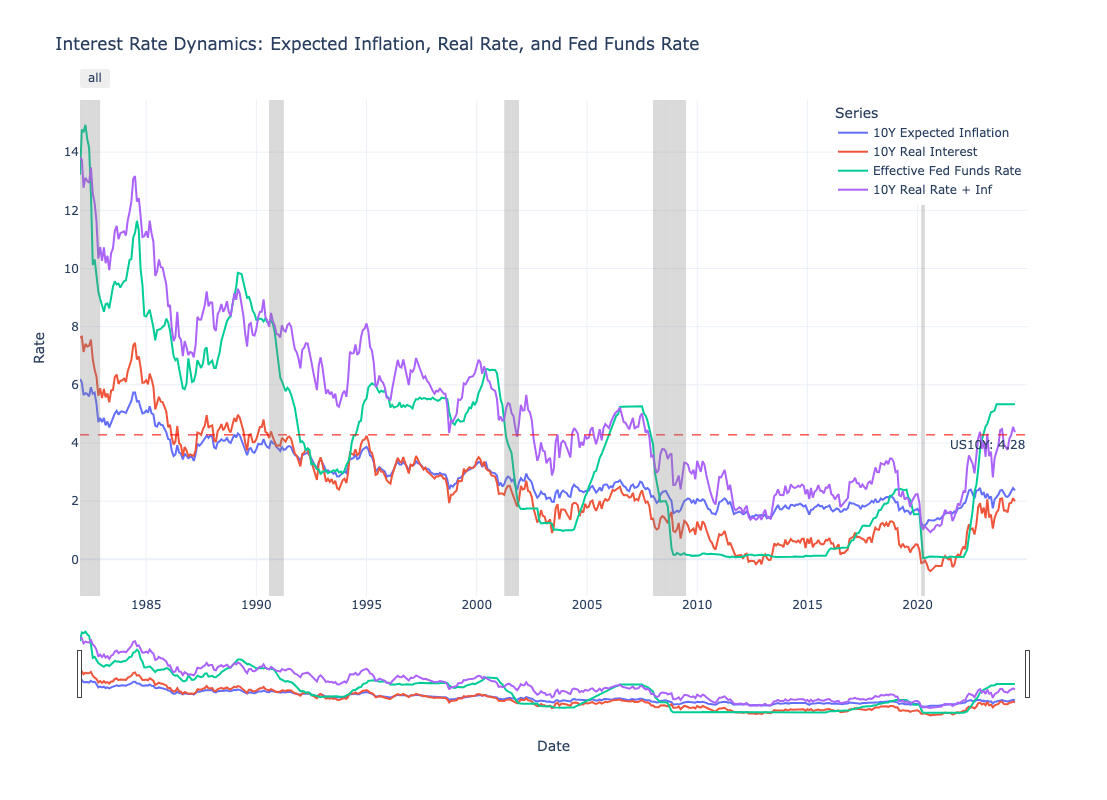

In [7]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sys
import os
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import importlib
import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def constructDF():
    """
    Constructs the RealFlation DataFrame by fetching data from the FRED API.

    Returns:
        pd.DataFrame: DataFrame containing the data for 'EXPINF10YR', 
                      'REAINTRATREARAT10Y', 'FEDFUNDS', and 'Real10YrInflInterest'.
    """
    expinf10yr = SeriesFetcher('EXPINF10YR')
    reaintratrearat10y = SeriesFetcher('REAINTRATREARAT10Y')
    fedfunds = SeriesFetcher('FEDFUNDS')

    data = pd.DataFrame({
        'EXPINF10YR': expinf10yr.get_series_data(),
        'REAINTRATREARAT10Y': reaintratrearat10y.get_series_data(),
        'FEDFUNDS': fedfunds.get_series_data()
    })

    # Drop rows with missing values & Convert index to datetime
    data.dropna(inplace=True)
    data.index = pd.to_datetime(data.index)
    
    # Create the Real10YrInflInterest series
    data['Real10YrInflInterest'] = data['REAINTRATREARAT10Y'] + data['EXPINF10YR']
    
    return data

def shade_recession_months(fig, usrec_series):
    """
    Shades the recession months based on the "USREC" series.

    Parameters:
        fig (plotly.graph_objs._figure.Figure): The Plotly Figure object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            fig.add_vrect(
                x0=date, x1=date + pd.DateOffset(months=1),
                fillcolor="grey", opacity=0.3, line_width=0
            )

if __name__ == "__main__":
    today = pd.Timestamp.now().date()
    offset_days = 200

    # Construct the RealFlation DataFrame & establish min/max indexed date
    RealFlation = constructDF()
    data_start_date = RealFlation.index.min()
    data_end_date = RealFlation.index.max()
    
    # Create Plotly figure & Add traces for each series
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['EXPINF10YR'], mode='lines', name='10Y Expected Inflation'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['REAINTRATREARAT10Y'], mode='lines', name='10Y Real Interest'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['FEDFUNDS'], mode='lines', name='Effective Fed Funds Rate'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['Real10YrInflInterest'], mode='lines', name='10Y Real Rate + Inf'))

    # Fetch the current 10-year Treasury yield (DGS10) and display it as a reference
    dgs10 = SeriesFetcher('DGS10')
    current_dgs10 = dgs10.get_latest_value()
    if current_dgs10 is not None:
        fig.add_hline(y=current_dgs10, line=dict(color='red', width=1, dash='dash'), annotation_text=f'US10Y: {current_dgs10}', annotation_position='bottom right')
    else:
        print("Failed to fetch the current 10-year Treasury yield.")

    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data(data_start_date)
    shade_recession_months(fig, usrec_series)
    
    # Update layout with correct x-axis range and range slider range
    fig.update_layout(
        title='Interest Rate Dynamics: Expected Inflation, Real Rate, and Fed Funds Rate',
        xaxis_title='Date',
        yaxis_title='Rate',
        legend_title='Series',
        legend=dict(
            x=1,
            y=1,
            xanchor='right',
            yanchor='top',
        ),
        template='plotly_white',
        width=1100,  # Set the width of the chart
        height=800,  # Set the height of the chart
        xaxis=dict(
            rangeselector=dict(buttons=list([
                dict(step="all")
            ])),
            rangeslider=dict(
                visible=True,
                autorange=True,
                yaxis=dict(
                        # rangemode="match",  # Ensures the y-axis matches the main plot
                        # autorange=True,     # Automatically adjust y-axis range
                        # fixedrange=True    # Allow y-axis range to be adjusted
                    )
            ), 
            type="date",
            range=[data_start_date, data_end_date + pd.DateOffset(days=offset_days)]
        ),
        yaxis=dict(
            autorange=True,  # Enable dynamic y-axis scaling
            fixedrange=False
        )
    )
    
    # Show the figure
    fig.show()


In [25]:
RealFlation

,EXPINF10YR,REAINTRATREARAT10Y,FEDFUNDS,Real10YrInflInterest
1982-01-01,6.197611,7.623742,13.22,13.821354
1982-02-01,6.079232,7.656648,14.78,13.735880
1982-03-01,5.648130,7.128993,14.68,12.777123
1982-04-01,5.713188,7.408347,14.94,13.121536
1982-05-01,5.689980,7.320041,14.45,13.010021
...,...,...,...,...
2024-02-01,2.146201,1.616823,5.33,3.763024
2024-03-01,2.218753,1.925969,5.33,4.144722
2024-04-01,2.342961,1.938194,5.33,4.281155
2024-05-01,2.451501,2.103399,5.33,4.554900
